In [1]:
# Install required packages
import subprocess
import sys

packages = [
    'torch',
    'transformers',
    'datasets',
    'peft',
    'bitsandbytes',
    'trl',
    'scikit-learn',
    'pandas',
    'numpy',
    'tqdm',
    'matplotlib',
    'seaborn',
    'rouge-score'
]

for package in packages:
    print(f"Installing {package}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("\n✓ All packages installed successfully!")

Installing torch...
Installing transformers...
Installing datasets...
Installing peft...
Installing bitsandbytes...
Installing trl...
Installing scikit-learn...
Installing pandas...
Installing numpy...
Installing tqdm...
Installing matplotlib...
Installing seaborn...
Installing rouge-score...

✓ All packages installed successfully!


In [2]:
# Import libraries
import torch
import json
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
)
from datasets import Dataset, DatasetDict
from peft import LoraConfig, get_peft_model
from trl import SFTTrainer
import matplotlib.pyplot as plt
import seaborn as sns

# Set up visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

✓ Libraries imported successfully!
✓ PyTorch version: 2.9.0+cu126
✓ CUDA available: True
✓ GPU: Tesla T4


In [3]:
# Device and configuration setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Configuration
DATA_DIR = Path("/content/drive/MyDrive/Pikky/data")
OUTPUT_DIR = Path("/content/drive/MyDrive/Pikky/models")
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

# Verify data files exist
train_file = DATA_DIR / "train.json"
dev_file = DATA_DIR / "dev.json"
test_file = DATA_DIR / "test.json"

for f in [train_file, dev_file, test_file]:
    if f.exists():
        print(f"✓ {f.name} found")
    else:
        print(f"✗ {f.name} NOT found")

Device: cuda
Data directory: /content/drive/MyDrive/Pikky/data
Output directory: /content/drive/MyDrive/Pikky/models
✓ train.json found
✓ dev.json found
✓ test.json found


In [4]:
# Load sample data to understand structure
def load_jsonl(file_path, num_samples=5):
    """Load and display samples from JSONL file"""
    samples = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i < num_samples:
                samples.append(json.loads(line))
            else:
                break
    return samples

# Load and display sample
samples = load_jsonl(train_file, num_samples=2)

print("Sample Data Structure:")
print("="*80)
for i, sample in enumerate(samples, 1):
    print(f"\nSample {i}:")
    print(f"Question: {sample['question'][:100]}...")
    print(f"Answer: {sample['exp'][:150]}...")
    print(f"Options: A) {sample['opa'][:50]}... B) {sample['opb'][:50]}...")
    print(f"Subject: {sample['subject_name']}")
    print(f"Topic: {sample['topic_name']}")
    print(f"Choice Type: {sample['choice_type']}")
    print("-"*80)

Sample Data Structure:

Sample 1:
Question: Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in...
Answer: Chronic urethral obstruction because of urinary calculi, prostatic hyperophy, tumors, normal pregnancy, tumors, uterine prolapse or functional disorde...
Options: A) Hyperplasia... B) Hyperophy...
Subject: Anatomy
Topic: Urinary tract
Choice Type: single
--------------------------------------------------------------------------------

Sample 2:
Question: Which vitamin is supplied from only animal source:...
Answer: Ans. (c) Vitamin B12 Ref: Harrison's 19th ed. P 640* Vitamin B12 (Cobalamin) is synthesized solely by microorganisms.* In humans, the only source for ...
Options: A) Vitamin C... B) Vitamin B7...
Subject: Biochemistry
Topic: Vitamins and Minerals
Choice Type: single
--------------------------------------------------------------------------------


In [5]:
# Count records in each file
def count_records(file_path):
    """Count total records in JSONL file"""
    count = 0
    with open(file_path, 'r', encoding='utf-8') as f:
        for _ in f:
            count += 1
    return count

train_count = count_records(train_file)
dev_count = count_records(dev_file)
test_count = count_records(test_file)

print("Dataset Statistics:")
print(f"Training samples: {train_count:,}")
print(f"Development samples: {dev_count:,}")
print(f"Test samples: {test_count:,}")
print(f"Total samples: {train_count + dev_count + test_count:,}")

Dataset Statistics:
Training samples: 182,822
Development samples: 4,183
Test samples: 6,150
Total samples: 193,155


In [6]:
# Analyze text lengths and subject distribution
def analyze_dataset(file_path, num_samples=1000):
    """Analyze dataset statistics"""
    questions_len = []
    answers_len = []
    subjects = {}
    choice_types = {}

    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if i >= num_samples:
                break
            record = json.loads(line)

            question_text = record.get('question')
            if question_text is not None:
                questions_len.append(len(question_text.split()))
            else:
                questions_len.append(0) # Treat None as 0 words

            answer_text = record.get('exp')
            if answer_text is not None:
                answers_len.append(len(answer_text.split()))
            else:
                answers_len.append(0) # Treat None as 0 words

            subject = record.get('subject_name', 'Unknown')
            subjects[subject] = subjects.get(subject, 0) + 1
            choice_type = record.get('choice_type', 'Unknown')
            choice_types[choice_type] = choice_types.get(choice_type, 0) + 1

    return {
        'question_lengths': questions_len,
        'answer_lengths': answers_len,
        'subjects': subjects,
        'choice_types': choice_types
    }

# Analyze training data
analysis = analyze_dataset(train_file, num_samples=5000)

print("\nText Length Statistics:")
print(f"Questions - Mean: {np.mean(analysis['question_lengths']):.1f} words, "
      f"Max: {np.max(analysis['question_lengths'])}, "
      f"Min: {np.min(analysis['question_lengths'])}")
print(f"Answers - Mean: {np.mean(analysis['answer_lengths']):.1f} words, "
      f"Max: {np.max(analysis['answer_lengths'])}, "
      f"Min: {np.min(analysis['answer_lengths'])}")

print("\nTop Medical Subjects:")
for subject, count in sorted(analysis['subjects'].items(), key=lambda x: x[1], reverse=True)[:10]:
    print(f"  {subject}: {count}")

print("\nQuestion Type Distribution:")
for choice_type, count in analysis['choice_types'].items():
    print(f"  {choice_type}: {count}")


Text Length Statistics:
Questions - Mean: 12.7 words, Max: 141, Min: 1
Answers - Mean: 68.3 words, Max: 1179, Min: 0

Top Medical Subjects:
  Medicine: 500
  Surgery: 447
  Pathology: 417
  Anatomy: 389
  Pharmacology: 354
  Social & Preventive Medicine: 337
  Microbiology: 285
  Gynaecology & Obstetrics: 274
  Physiology: 253
  Dental: 244

Question Type Distribution:
  single: 3333
  multi: 1667


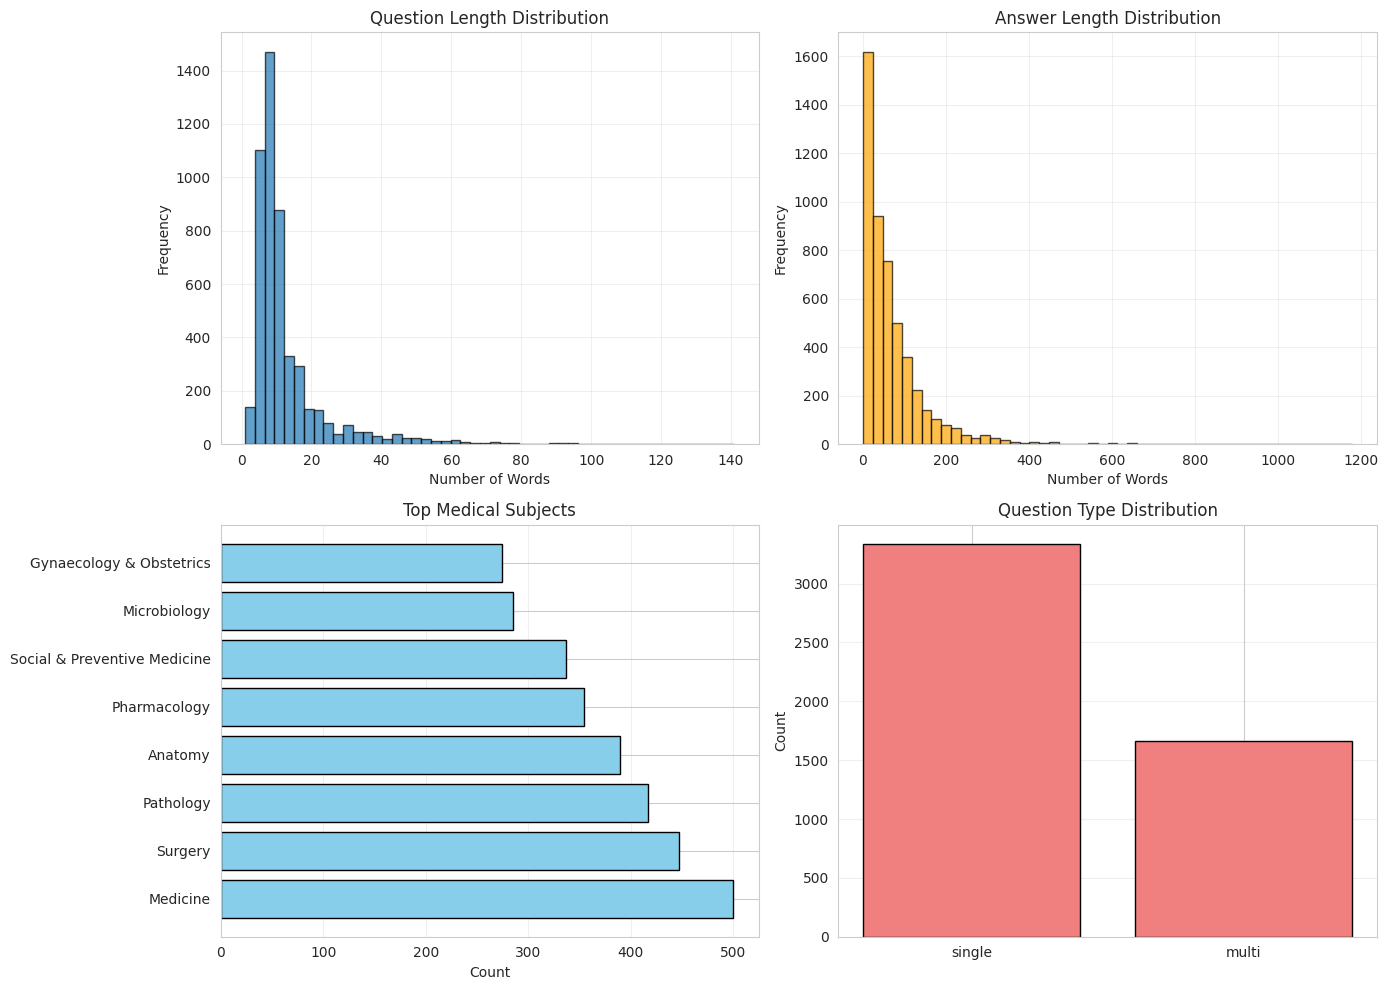

✓ Analysis plot saved to models/data_analysis.png


In [7]:
# Visualize data distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Question length distribution
axes[0, 0].hist(analysis['question_lengths'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Number of Words')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Question Length Distribution')
axes[0, 0].grid(alpha=0.3)

# Answer length distribution
axes[0, 1].hist(analysis['answer_lengths'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_xlabel('Number of Words')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Answer Length Distribution')
axes[0, 1].grid(alpha=0.3)

# Top subjects
top_subjects = sorted(analysis['subjects'].items(), key=lambda x: x[1], reverse=True)[:8]
subjects_names, subjects_counts = zip(*top_subjects)
axes[1, 0].barh(subjects_names, subjects_counts, color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Count')
axes[1, 0].set_title('Top Medical Subjects')
axes[1, 0].grid(alpha=0.3, axis='x')

# Choice types
choice_types_names, choice_types_counts = zip(*analysis['choice_types'].items())
axes[1, 1].bar(choice_types_names, choice_types_counts, color='lightcoral', edgecolor='black')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Question Type Distribution')
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'data_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("✓ Analysis plot saved to models/data_analysis.png")

In [8]:
# Load and preprocess data
def load_and_format_dataset(file_path, num_samples=None):
    """Load JSONL file and format as conversation pairs

    Args:
        file_path: Path to JSONL file
        num_samples: Maximum number of samples to load (None = all)
    """
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f):
            if num_samples is not None and i >= num_samples:
                break
            record = json.loads(line)
            # Use .get() with a default empty string to handle missing keys gracefully
            question_text = record.get('question', '')
            exp_text = record.get('exp', '')

            # Create conversational format
            prompt = f"""Question: {question_text}

Answer: {exp_text}"""
            data.append({"text": prompt})
    return data

# Load all datasets
print("Loading datasets...")
# Load only 2000 training samples for faster training
train_data = load_and_format_dataset(train_file, num_samples=2000)
dev_data = load_and_format_dataset(dev_file,num_samples=500)  # Use full dev set for evaluation
test_data = load_and_format_dataset(test_file,num_samples=1000)  # Use full test set for evaluation

print(f"✓ Loaded {len(train_data)} training samples (reduced to 2K for faster training)")
print(f"✓ Loaded {len(dev_data)} development samples")
print(f"✓ Loaded {len(test_data)} test samples")

# Display sample
print("\nSample formatted data:")
print("="*80)
print(train_data[0]['text'])
print("="*80)

Loading datasets...
✓ Loaded 2000 training samples (reduced to 2K for faster training)
✓ Loaded 500 development samples
✓ Loaded 1000 test samples

Sample formatted data:
Question: Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma

Answer: Chronic urethral obstruction because of urinary calculi, prostatic hyperophy, tumors, normal pregnancy, tumors, uterine prolapse or functional disorders cause hydronephrosis which by definition is used to describe dilatation of renal pelvis and calculus associated with progressive atrophy of the kidney due to obstruction to the outflow of urine Refer Robbins 7yh/9,1012,9/e. P950


In [9]:
# Create HuggingFace Datasets
train_dataset = Dataset.from_dict({"text": [d["text"] for d in train_data]})
eval_dataset = Dataset.from_dict({"text": [d["text"] for d in dev_data]})
test_dataset = Dataset.from_dict({"text": [d["text"] for d in test_data]})

# Create DatasetDict
dataset_dict = DatasetDict({
    "train": train_dataset,
    "eval": eval_dataset,
    "test": test_dataset
})

print("Dataset Dictionary:")
print(dataset_dict)
print("\nExample from training set:")
print(train_dataset[0]["text"][:200])

Dataset Dictionary:
DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 2000
    })
    eval: Dataset({
        features: ['text'],
        num_rows: 500
    })
    test: Dataset({
        features: ['text'],
        num_rows: 1000
    })
})

Example from training set:
Question: Chronic urethral obstruction due to benign prismatic hyperplasia can lead to the following change in kidney parenchyma

Answer: Chronic urethral obstruction because of urinary calculi, prost


In [10]:
# Model configuration
model_name = "meta-llama/Llama-3.2-1B"  # Change to 13b if you have more VRAM
# For gated models, you may need to login: huggingface-cli login

print(f"Loading model: {model_name}")
print(f"Device: {device}")

# 4-bit quantization configuration for QLoRA
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",  # 4-bit NormalFloat type
    bnb_4bit_use_double_quant=True,  # Double quantization for better accuracy
    bnb_4bit_compute_dtype=torch.bfloat16,  # Computation dtype
)

print("Quantization config created:")
print(f"  - 4-bit quantization: Enabled")
print(f"  - Quantization type: NormalFloat4 (nf4)")
print(f"  - Double quantization: Enabled")
print(f"  - Compute dtype: bfloat16")

Loading model: meta-llama/Llama-3.2-1B
Device: cuda
Quantization config created:
  - 4-bit quantization: Enabled
  - Quantization type: NormalFloat4 (nf4)
  - Double quantization: Enabled
  - Compute dtype: bfloat16


In [31]:
# Load model with quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True,
    use_auth_token=True,  # Set to your HF token if model is gated
)

print("✓ Model loaded successfully!")
print(f"Model: {model_name}")
print(f"Device map: auto (distributed across available devices)")

✓ Model loaded successfully!
Model: meta-llama/Llama-3.2-1B
Device map: auto (distributed across available devices)


In [12]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    trust_remote_code=True,
    use_auth_token=True,
)

# Set pad token
tokenizer.pad_token = tokenizer.eos_token

print("✓ Tokenizer loaded successfully!")
print(f"Vocab size: {len(tokenizer)}")
print(f"Pad token: {tokenizer.pad_token}")
print(f"EOS token: {tokenizer.eos_token}")

tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/301 [00:00<?, ?B/s]

✓ Tokenizer loaded successfully!
Vocab size: 128256
Pad token: <|end_of_text|>
EOS token: <|end_of_text|>


In [13]:
# LoRA configuration
lora_config = LoraConfig(
    r=16,  # LoRA rank
    lora_alpha=32,  # LoRA alpha (scaling factor)
    target_modules=["q_proj", "v_proj"],  # Target attention layers
    lora_dropout=0.05,  # Dropout for regularization
    bias="none",
    task_type="CAUSAL_LM"
)

print("LoRA Configuration:")
print(f"  - Rank (r): {lora_config.r}")
print(f"  - Alpha: {lora_config.lora_alpha}")
print(f"  - Target modules: {lora_config.target_modules}")
print(f"  - Dropout: {lora_config.lora_dropout}")
print(f"  - Task type: {lora_config.task_type}")

LoRA Configuration:
  - Rank (r): 16
  - Alpha: 32
  - Target modules: {'q_proj', 'v_proj'}
  - Dropout: 0.05
  - Task type: CAUSAL_LM


In [14]:
# Apply LoRA to model
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

# Prepare model for training
model.config.use_cache = False
model.config.pretraining_tp = 1

print("✓ LoRA adapters applied successfully!")
print("✓ Model ready for training")

trainable params: 1,703,936 || all params: 1,237,518,336 || trainable%: 0.1377
✓ LoRA adapters applied successfully!
✓ Model ready for training


In [21]:
# Training arguments
training_args = TrainingArguments(
    output_dir=str(OUTPUT_DIR / "checkpoints"),
    overwrite_output_dir=True,
    per_device_train_batch_size=2,  # Adjust based on VRAM
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,  # Simulate larger batch size
    num_train_epochs=3,
    learning_rate=2e-4,
    warmup_steps=100,
    weight_decay=0.001,
    bf16=True,  # Use bfloat16 if available
    logging_dir=str(OUTPUT_DIR / "logs"),
    logging_steps=10,
    save_steps=500,
    eval_steps=500,
    save_total_limit=3,
    eval_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    report_to="tensorboard",
    remove_unused_columns=False, # Keep the 'text' column for SFTTrainer
)

print("Training Arguments:")
print(f"  - Output directory: {training_args.output_dir}")
print(f"  - Batch size (per device): {training_args.per_device_train_batch_size}")
print(f"  - Gradient accumulation: {training_args.gradient_accumulation_steps}")
print(f"  - Num epochs: {training_args.num_train_epochs}")
print(f"  - Learning rate: {training_args.learning_rate}")
print(f"  - Warmup steps: {training_args.warmup_steps}")

Training Arguments:
  - Output directory: /content/drive/MyDrive/Pikky/models/checkpoints
  - Batch size (per device): 2
  - Gradient accumulation: 8
  - Num epochs: 3
  - Learning rate: 0.0002
  - Warmup steps: 100


In [16]:
# Initialize SFT Trainer
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["eval"],
    args=training_args
)

print("✓ SFT Trainer initialized successfully!")

Adding EOS to train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/500 [00:00<?, ? examples/s]

✓ SFT Trainer initialized successfully!


In [18]:
# Start training
print("Starting training...")
print("="*80)

train_result = trainer.train()

print("="*80)
print("✓ Training completed!")
print(f"\nTraining Results:")
print(f"  - Training loss: {train_result.training_loss:.4f}")
print(f"  - Training samples processed: {int(train_result.global_step * training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)}")

Starting training...


Step,Training Loss,Validation Loss


✓ Training completed!

Training Results:
  - Training loss: 2.1090
  - Training samples processed: 6000


In [19]:
# Save model and tokenizer
model_save_path = OUTPUT_DIR / "medical_chatbot_llama2_qlora"
model_save_path.mkdir(parents=True, exist_ok=True)

trainer.model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"✓ Model saved to {model_save_path}")
print(f"  - LoRA adapters: adapter_config.json, adapter_model.bin")
print(f"  - Tokenizer: tokenizer_config.json, tokenizer.model, tokenizer.json")

✓ Model saved to /content/drive/MyDrive/Pikky/models/medical_chatbot_llama2_qlora
  - LoRA adapters: adapter_config.json, adapter_model.bin
  - Tokenizer: tokenizer_config.json, tokenizer.model, tokenizer.json


In [ ]:
# Load training history and plot
import os
from pathlib import Path

# Load training logs
log_file = Path(training_args.logging_dir) / "events.out.tfevents.*"
log_files = list(Path(training_args.logging_dir).glob("events.out.tfevents.*"))

if log_files:
    print("Training logs found. You can view detailed metrics using TensorBoard:")
    print(f"  tensorboard --logdir {training_args.logging_dir}")
else:
    print("No TensorBoard logs found (this is normal if using minimal logging)")


print("\n✓ Model training and evaluation completed successfully!")

Training logs found. You can view detailed metrics using TensorBoard:
  tensorboard --logdir /content/drive/MyDrive/Pikky/models/logs

✓ Model training and evaluation completed successfully!


In [23]:
# Load fine-tuned model for inference
from peft import AutoPeftModelForCausalLM

print("Loading fine-tuned model for inference...")

# Load model and merge LoRA weights (optional, for deployment)
# For testing, we can use trainer.model directly
inference_model = trainer.model
inference_tokenizer = tokenizer

print("✓ Model loaded successfully!")

Loading fine-tuned model for inference...
✓ Model loaded successfully!


In [28]:
# Load fine-tuned model for inference
print("Loading fine-tuned model for inference...")

inference_model = trainer.model

# ---- IMPORTANT FIX ----
# Convert FP16 model (from training) to FP32 for CPU inference
inference_model = inference_model.to(torch.float32)
inference_model = inference_model.to(device)
inference_model.eval()
# -----------------------

inference_tokenizer = tokenizer

print("✓ Model loaded successfully!")


Loading fine-tuned model for inference...
✓ Model loaded successfully!


In [29]:
# Medical Chatbot Inference Function
def medical_chatbot(question, max_length=256, temperature=0.7):
    """
    Generate an answer to a medical question using the fine-tuned model.

    Args:
        question: Medical question string
        max_length: Maximum length of generated response
        temperature: Sampling temperature (higher = more creative)

    Returns:
        Generated answer
    """
    # Format input
    prompt = f"Question: {question}\n\nAnswer:"

    # Tokenize
    input_ids = inference_tokenizer.encode(prompt, return_tensors="pt").to(device)

    # Generate
    with torch.no_grad():
        output = inference_model.generate(
            input_ids,
            max_length=max_length,
            temperature=temperature,
            top_p=0.95,
            do_sample=True,
            pad_token_id=inference_tokenizer.eos_token_id,
        )

    # Decode
    response = inference_tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract answer part
    if "Answer:" in response:
        answer = response.split("Answer:")[1].strip()
    else:
        answer = response

    return answer

print("✓ Medical chatbot function created")

✓ Medical chatbot function created


In [30]:
# Test inference on sample medical questions
test_questions = [
    "What are the symptoms of myocardial infarction?",
    "Explain the process of DNA replication in cells",
    "What is the treatment for acute asthma attack?"
]

print("Medical Chatbot - Inference Examples")
print("="*80)

for i, question in enumerate(test_questions, 1):
    print(f"\n[Question {i}]")
    print(f"Q: {question}")
    try:
        answer = medical_chatbot(question, max_length=200, temperature=0.5)
        print(f"A: {answer}")
    except Exception as e:
        print(f"Error generating answer: {str(e)}")
    print("-"*80)

Medical Chatbot - Inference Examples

[Question 1]
Q: What are the symptoms of myocardial infarction?
A: Symptoms of MI include chest pain, nausea, vomiting, diaphoresis, cold sweat, sweating, palpitations, hypotension, syncope, and lightheadedness.
--------------------------------------------------------------------------------

[Question 2]
Q: Explain the process of DNA replication in cells
A: The process of DNA replication is a fundamental process in the life cycle of all living organisms. DNA replication is the process of copying the genetic material, DNA, in the cell. DNA is the genetic material of all living organisms. It is a long strand of DNA that contains the instructions for the synthesis of proteins. DNA is found in the nucleus of the cell. The replication of DNA is essential for the production of new DNA molecules that are identical to the old ones. The DNA replication process is carried out by the enzyme DNA polymerase. The DNA replication process is divided into two phas